### Import Necessary Packages

In [ ]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

#ignore annoying warning (from sklearn and seaborn)
warnings.warn = ignore_warn 

import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
track_metadata_df = pd.read_csv('/content/gdrive/MyDrive/Kaazima/EchonestDataset/song_data.csv')
count_play_df =pd.read_csv('/content/gdrive/MyDrive/Kaazima/EchonestDataset/10000.txt', sep='\t', header=None, names=['user','song','play_count'])

### Song_data.csv

In [ ]:
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
display(track_metadata_df.head())

Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


Clearly, we have repeated track metadata.

### 10000.txt

In [ ]:
print('No of rows:', count_play_df.shape[0])
print('Number of unique users:', len(count_play_df.user.unique()))
display(count_play_df.head())

No of rows: 2000000
Number of unique users: 76353


,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


### Merge Datasets

Merge song_data.csv and 10000.txt based on the song_id.

In [ ]:
track_metadata_df.rename(columns = {'song_id': 'song'},inplace=True)
user_song_list_count = pd.merge(count_play_df, track_metadata_df.drop_duplicates(['song']), on='song', how ='left')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
display(user_song_list_count.head())

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


### Analysis on the listen count

In [ ]:
user_song_list_count.listen_count.describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
listen_count,2e+06,3.04548,6.57972,1,1,1,3,2213


Clearly, we have some users obsessed with a single song! A user having heard 2,213 times a single song is something very extreme considering that we have only 3 times in the third quartile.

Song listened by the most obsessed user

In [ ]:
print('{:d} users, {:.2%} of total play counts, listening a single more than 200 times'.format(
    count_play_df.user[count_play_df.play_count>200].unique().shape[0],
    count_play_df.play_count[count_play_df.play_count>200].count()/count_play_df.shape[0]))
display(count_play_df.play_count[count_play_df.play_count>200].describe().reset_index().T)

118 users, 0.01% of total play counts, listening a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,140,327.107,209.115,201,225,267,353.75,2213


In [ ]:
print('The song listened by the most obsessed user:')
display(track_metadata_df[track_metadata_df.song.isin(
                  count_play_df[count_play_df.play_count==2213].song.values)])

The song listened by the most obsessed user:


,song,title,release,artist_name,year
567847,SOFCGSE12AF72A674F,Starshine,Gorillaz,Gorillaz,2000


Song listened by the second most obsessed user

In [ ]:
display(count_play_df.play_count[count_play_df.play_count>900].describe().reset_index().T)

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,2,1566.5,914.289,920,1243.25,1566.5,1889.75,2213


In [ ]:
print('The song listened by the second most obsessed user:')
display(track_metadata_df[track_metadata_df.song.isin(
                  count_play_df[count_play_df.play_count==920].song.values)])

The song listened by the second most obsessed user:


,song,title,release,artist_name,year
927746,SOUAGPQ12A8AE47B3A,Crack Under Pressure,Stress related / Live and learn,Righteous Pigs,1998


***So we have to be careful when creating a recommendation system that can be affected by the outliers***

### Problem with outliers

In [ ]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution \n( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot \n(skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

In [ ]:
user_song_count_distribution = user_song_list_count[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)
user_song_count_distribution.title.describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
title,76353,26.1941,31.6251,1,9,16,31,711


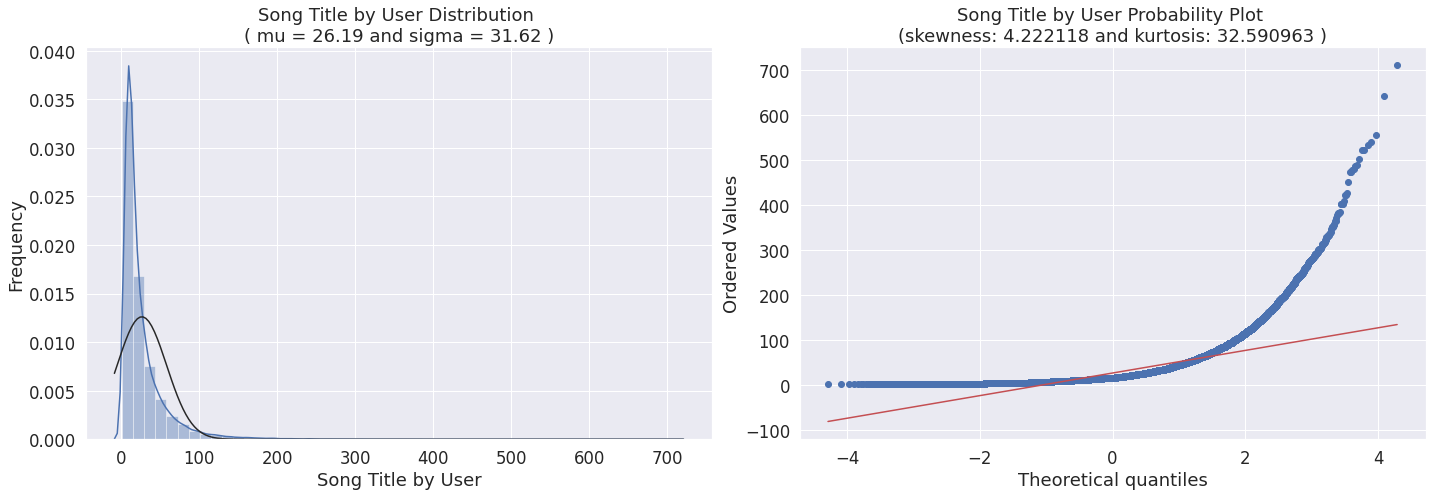

In [ ]:
QQ_plot(user_song_count_distribution.title, 'Song Title by User')

From *the distribution graph*, song title by user distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.. As we expect, less than a hundred listen a good number of different songs, but enough to raise the average to above 26.

From *the Probability Plot*, song title by user also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.

The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data is heavy-tailed or light-tailed relative to a normal distribution.So, with 32.6 of positive kurtosis song title by user are heavy-tailed and definitely has outliers.

### Top 20 items

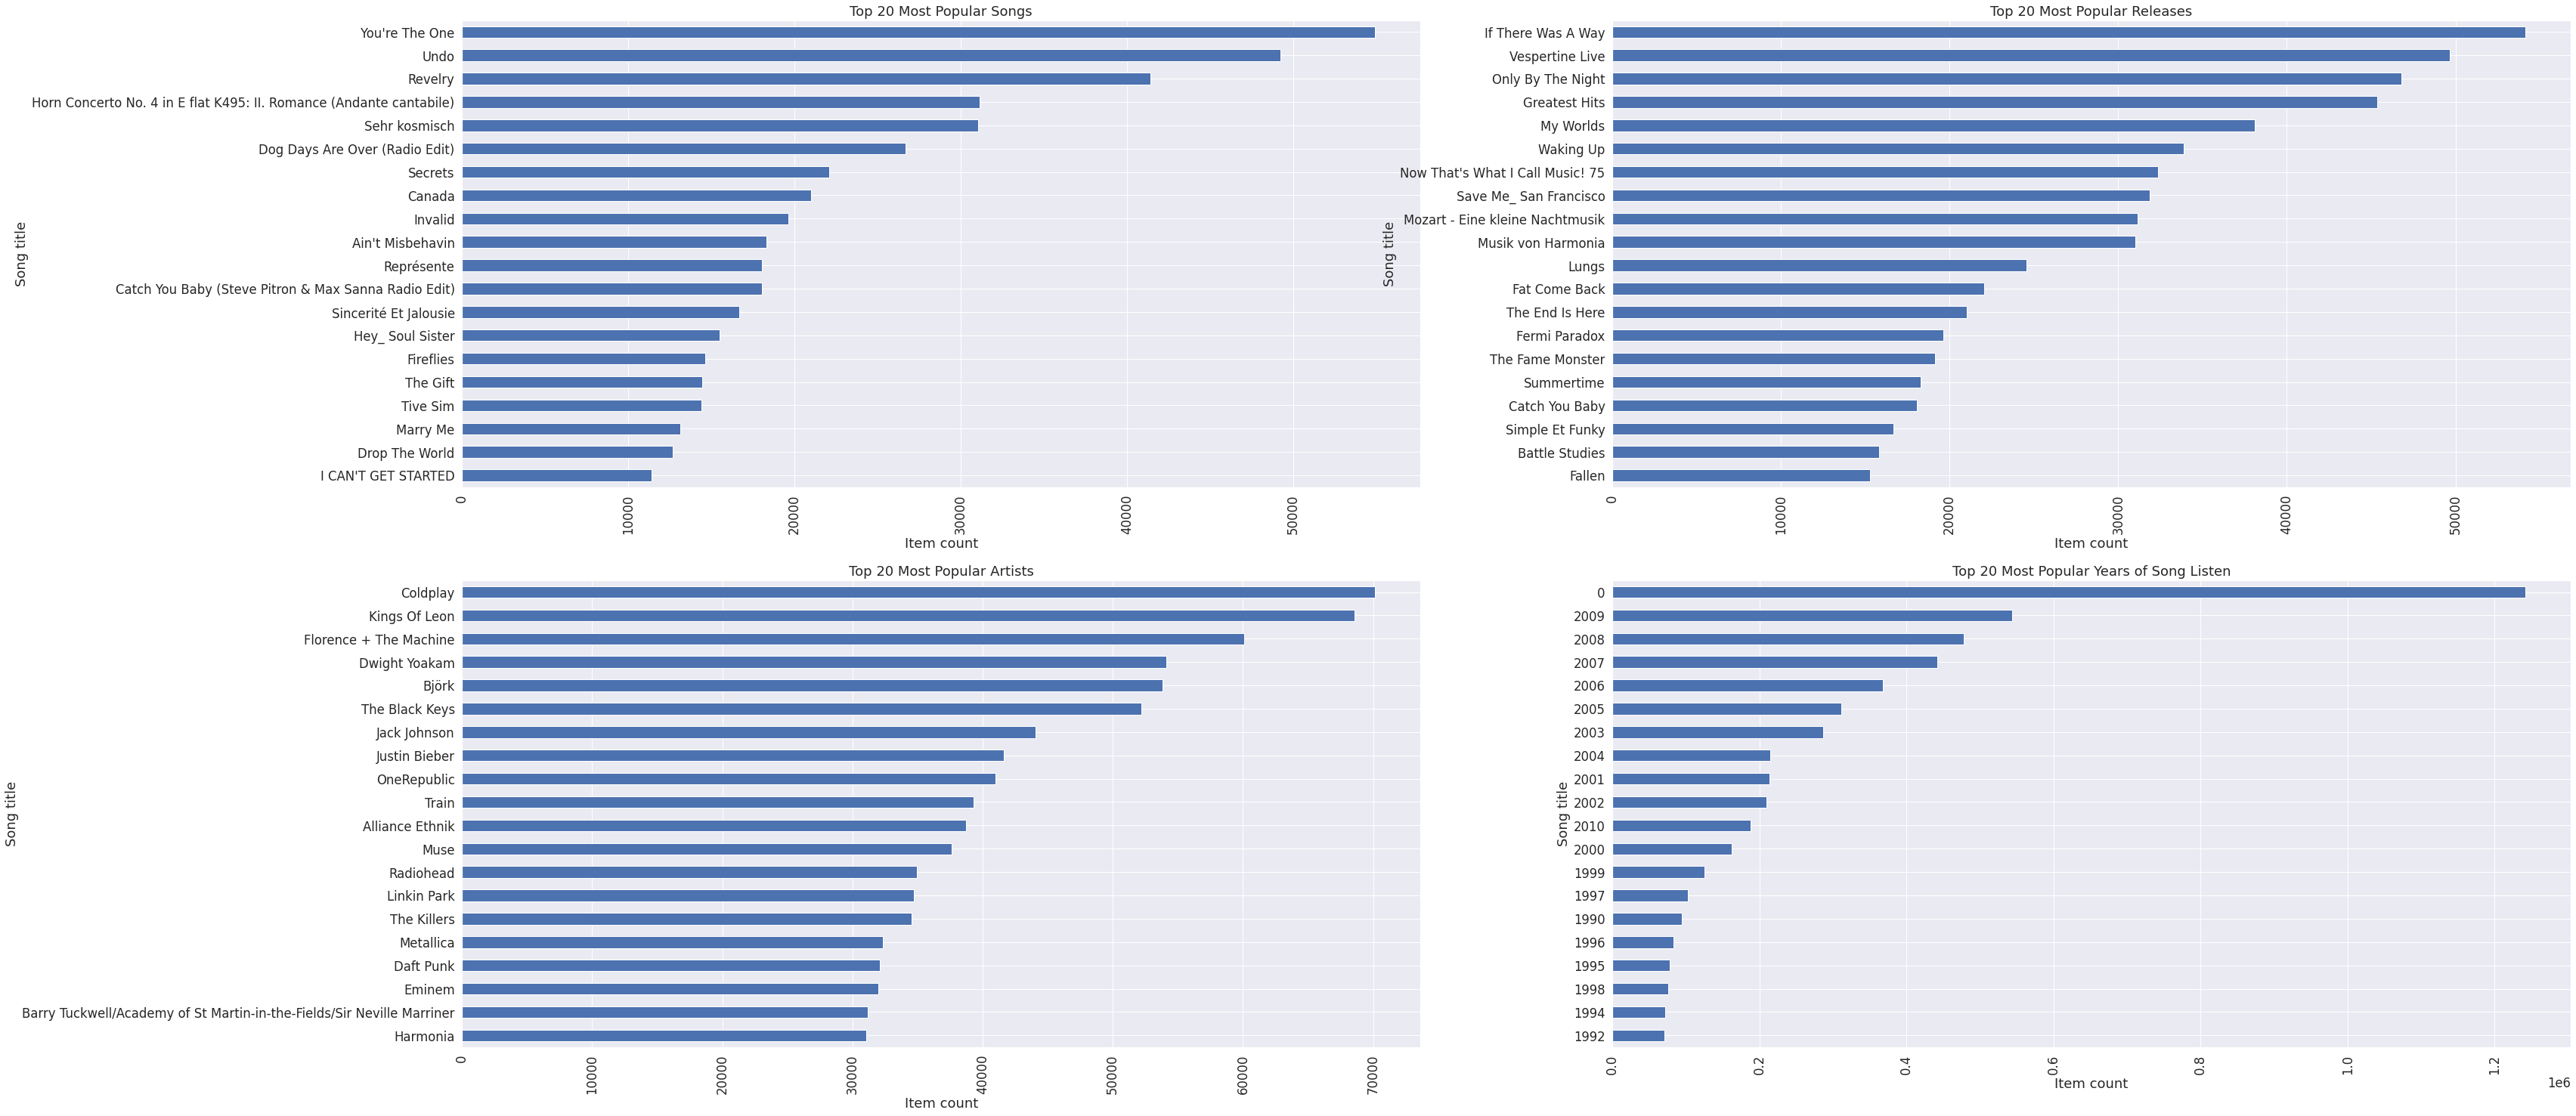

In [ ]:
# 4 Plots on a single figure
fig = plt.figure(figsize=(50, 25))

# Top 20 most popular songs
a1 = fig.add_subplot(221)
popular_songs = user_song_list_count[['title','listen_count']].groupby('title').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=a1)
plt.xticks(rotation='vertical')
plt.xlabel('Item count')
plt.ylabel('Song title')

# Top 20 most popular releases
a2 = fig.add_subplot(222)
popular_release = user_song_list_count[['release','listen_count']].groupby('release').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=a2)
plt.xticks(rotation='vertical')
plt.xlabel('Item count')
plt.ylabel('Song title')

# Top 20 most popular artists
a3 = fig.add_subplot(223)
popular_artist = user_song_list_count[['artist_name','listen_count']].groupby('artist_name').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=a3)
plt.xticks(rotation='vertical')
plt.xlabel('Item count')
plt.ylabel('Song title')

# Top 20 most popular years of song release
a4 = fig.add_subplot(224)
popular_year = user_song_list_count[['year','listen_count']].groupby('year').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_year.plot(kind='barh', title='Top 20 Most Popular Years of Song Listen', legend=False, ax=a4)
plt.xticks(rotation='vertical')
plt.xlabel('Item count')
plt.ylabel('Song title')

plt.show()

Clearly, the two most obsessed fans did not influence any of the top 20.